In [11]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import utils
import pickle
from scipy.optimize import minimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
filename = 'data/forAbhi/Velocity_Data.mat'
data = scipy.io.loadmat(filename)
T4_arclight = data['data']*100.0
T4_gcamp = data['data2']*100.0

In [13]:
T4_arclight.shape, T4_gcamp.shape

((113, 48), (113, 48))

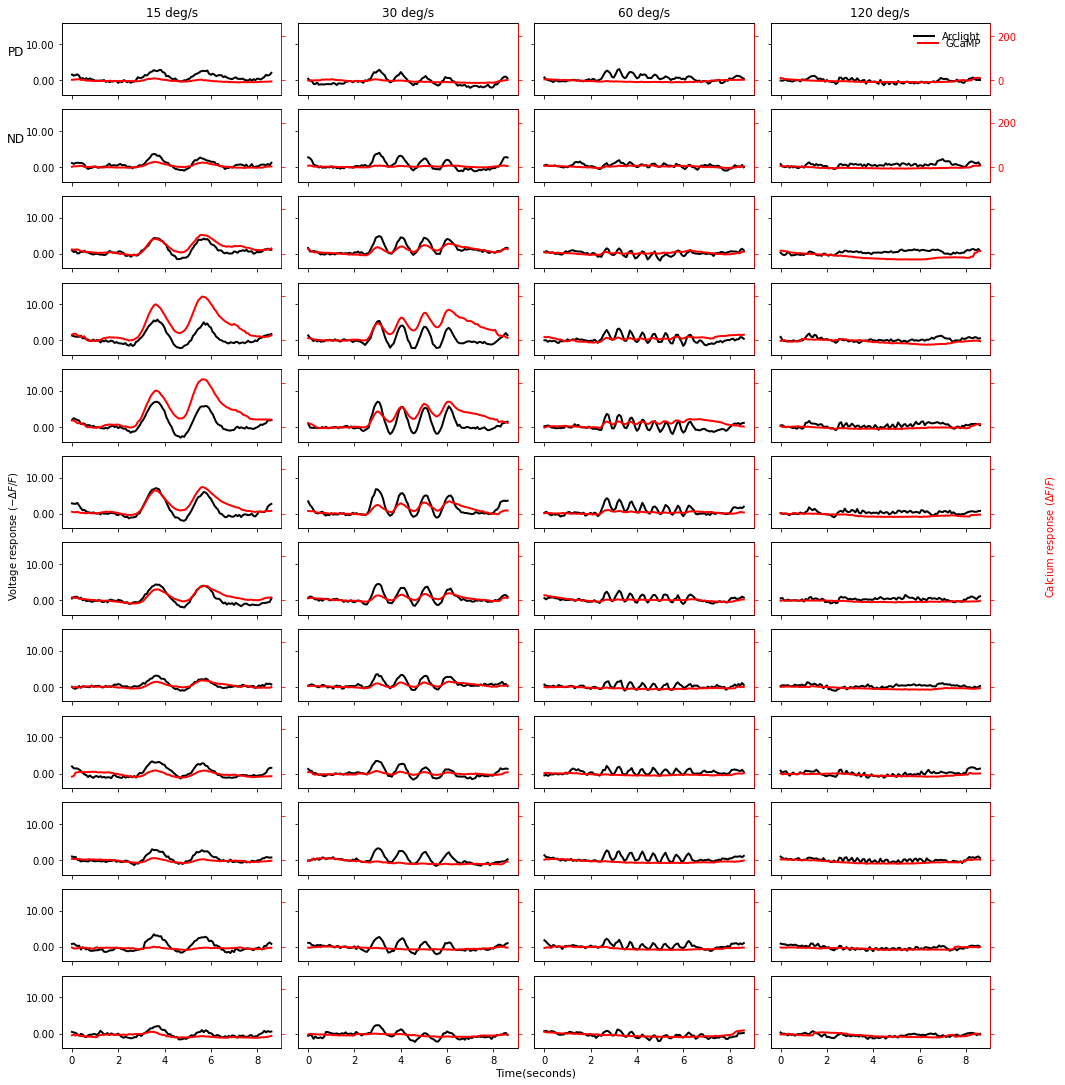

In [14]:
velocity = [15, 30, 60, 120]
#utils.plot_data_twinaxis([T4_arclight[10:,0:8], T4_gcamp[10:,0:8]], ylim=(-0.20,2.50), savefig=True, title='Gratings_SpeedPDND');
#utils.plot_data_twinaxis([T4_arclight, T4_gcamp], fig_size=(15,15),speed=velocity,ylim1=(-0.04,0.10),ylim2=(-0.30,2.60),savefig=False, title='Ori_Vel');
utils.plot_data_twinaxis([T4_arclight, T4_gcamp], fig_size=(15,15),speed=velocity,ylim1=(-4,10),ylim2=(-30,260),savefig=False, title='Ori_Vel');

In [21]:
global p_bounds 
#bounds on parameters (thres, tauhp, taulp1, gain1, taulp2, gain2, tshift)
#p_bounds = ((-300,350),(0,100),(0,500),(0,200),(0,500),(0,200),(-10,10)) 
#bounds on parameters (thres,taulp1, gain1, taulp2, gain2, tshift)
p_bounds = ((-300,350),(0,500),(0,200),(0,500),(0,200),(-10,10))
#p_bounds = ((-1,1),(0,5),(0,200),(0,5),(0,200),(-10,10))
#p_bounds = ((-3,4),(0,1),(0,2),(0,500),(0,5),(0,500),(-10,10))

def lowpass(x, tau, dt):
    y = np.zeros_like(x)
    n = x.shape[0]   #length of time dimension
    alpha = dt / (tau+dt)
    y[0] = x[0]
    for i in np.arange(1,n):
        y[i] = alpha*x[i] + (1-alpha)*y[i-1]
    return y

def highpass(x, tau, dt):
    y = x - lowpass(x, tau, dt)
    return y

def bandpass(x, tauhp, taulp, dt):
    y = highpass(x, tauhp, dt)
    y = lowpass(y, taulp, dt)
    return y

def threshold_cut(x, thres):
    x_copy = x.copy()
    x_copy[x_copy<thres] = 0
    return x_copy 

# def Ca_model(x, p, dt=0.0769):
#     """x is Arclight data. p is list of parameters. dt is timestep"""
#     (thres, tauhp, taulp1, gain1, taulp2, gain2, tshift) = p
#     x_thres = threshold_cut(x,thres/100.0)
#     x_thres_bp1 = bandpass(x_thres, tauhp/100, taulp1/100, dt)
#     x_1 = x_thres_bp1 * gain1
#     x_thres_bp2 = bandpass(x_thres, tauhp/100, taulp2/100, dt)
#     x_2 = x_thres_bp2 * gain2
#     y = x_1 + x_2
#     y = np.roll(y, int(tshift), axis=0)
#     return y

def Ca_model(x, p, fig_size=(15,15),dt=0.0769, plot=False):
    """x is Arclight data. p is list of parameters. dt is timestep"""
    (thres, taulp1, gain1, taulp2, gain2, tshift) = p
    x_thres = threshold_cut(x,thres/100.0)
    #x_thres = threshold_cut(x,thres)#/100.0)
    x_thres_lp1 = lowpass(x_thres, taulp1/100.0, dt)
    #x_thres_lp1 = lowpass(x_thres, taulp1, dt)
    x_1 = x_thres_lp1 * gain1
    x_thres_lp2 = lowpass(x_thres, taulp2/100.0, dt)
    #x_thres_lp2 = lowpass(x_thres, taulp2, dt)
    x_2 = x_thres_lp2 * gain2 * x_1
    y = x_1 + x_2
    y = np.roll(y, int(tshift), axis=0)
    if plot==True:
        utils.plot_data([x, x_thres, x_1, x_2, y], fig_size=(15,15),c=['k','grey','g','brown','r']);
    return y

def create_random_params():
    p = [np.random.uniform(bounds[0], bounds[1]) for bounds in p_bounds]
    #print(p)
    return p  

def calc_error(p):
    T4Ca_model = Ca_model(T4_arclight, p)
    #error1 = np.sqrt(np.mean((T4_Gcamp-T4Ca_model)**2)) #timeerror
    error1 = np.mean(np.sqrt(np.mean((T4_gcamp[10:90][:]-T4Ca_model[10:90][:])**2,axis=0)))
    error2 = np.sqrt(np.mean((T4_gcamp.max(axis=0)-T4Ca_model.max(axis=0))**2)) #peakerror
    timeerror = 1.0 #weight for time error
    error = timeerror*error1 + (1.0-timeerror)*error2 #peak error aand time error combined
    return error

def fit_params():
    p = create_random_params() #creates random parameter values
    #options = {'maxiter':5000} #maximum number of iterations
    res = minimize(calc_error, p, tol=1e-10, bounds=p_bounds)#options=options
    if res.success:
        print('Optimisation successful')
    else:
        print('Optimisation not succesfull')
    p = res.x
    error = calc_error(p)
    print('Remaining Error: ', format(calc_error(p),".2f"))
    print(res)
    return p, error

In [16]:
def many_runs(n):
    (p_list, err_list) = ([],[]) 
    for i in range(n):
        print('run : '+str(i))
        (par, err) = fit_params()
        print(par)
        p_list.append(par)
        err_list.append(err)
    return p_list, err_list
    

In [17]:
para_list, err_list = many_runs(100)

run : 0
Optimisation successful
Remaining Error:  14.06
      fun: 14.062687469119227
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00000000e+00, -1.77635795e-07, -2.47979415e-04, -1.77635795e-07,
       -1.24344880e-05, -0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 434
      nit: 43
     njev: 62
   status: 0
  success: True
        x: array([-1.36233050e+02,  7.97770730e+01,  4.59191798e-02,  1.15233992e+02,
        2.00000000e+02, -4.89778537e+00])
[-1.36233050e+02  7.97770730e+01  4.59191798e-02  1.15233992e+02
  2.00000000e+02 -4.89778537e+00]
run : 1
Optimisation successful
Remaining Error:  12.93
      fun: 12.93188920583703
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  3.73035170e-06, -1.28252964e-03, -2.13162955e-05,
       -2.30926206e-05, -0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 679
      nit: 76
     njev

Optimisation successful
Remaining Error:  15.77
      fun: 15.767182464937386
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00000000e+00,  1.30219380e-02, -2.64814666e+01,  5.19655387e-03,
       -3.06563420e-03,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 511
      nit: 39
     njev: 73
   status: 0
  success: True
        x: array([-2.82075115e+02,  9.89112444e+00,  1.88243093e-02,  4.85829179e+01,
        1.61755171e+02,  1.10828523e+00])
[-2.82075115e+02  9.89112444e+00  1.88243093e-02  4.85829179e+01
  1.61755171e+02  1.10828523e+00]
run : 15
Optimisation successful
Remaining Error:  15.95
      fun: 15.952088580181908
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00000000e+00, -5.32906629e-07,  2.35722553e-04,  5.32906629e-07,
       -2.84216869e-06, -0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1113
      nit: 119
     njev: 15

Optimisation successful
Remaining Error:  16.33
      fun: 16.333201701136588
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  3.20810247e-04,  5.32907052e-06, -3.09796827e-04,
        3.90798195e-06,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 238
      nit: 27
     njev: 34
   status: 0
  success: True
        x: array([2.08904035e+02, 1.27829648e+02, 4.81623517e-02, 1.01772590e+02,
       1.57642990e+02, 7.65250123e+00])
[2.08904035e+02 1.27829648e+02 4.81623517e-02 1.01772590e+02
 1.57642990e+02 7.65250123e+00]
run : 29
Optimisation successful
Remaining Error:  15.93
      fun: 15.930840151300918
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  1.05479985e-03, -1.24344979e-05,  1.92287075e-02,
        3.73034640e-06,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 210
      nit: 27
     njev: 30
   status: 0


Optimisation successful
Remaining Error:  13.39
      fun: 13.39077246223396
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  0.00000000e+00,  7.49622587e-05,  0.00000000e+00,
       -1.42108434e-05, -0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1351
      nit: 130
     njev: 193
   status: 0
  success: True
        x: array([ 1.84381742e+02,  1.34561425e+02,  7.13282683e-02,  1.34492247e+02,
        2.00000000e+02, -6.64498894e+00])
[ 1.84381742e+02  1.34561425e+02  7.13282683e-02  1.34492247e+02
  2.00000000e+02 -6.64498894e+00]
run : 43
Optimisation successful
Remaining Error:  17.10
      fun: 17.1028436802417
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00000000e+00,  0.00000000e+00,  2.06057393e-04,  4.61853068e-06,
        3.55271591e-06,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 490
      nit: 42
     njev: 70
 

Optimisation successful
Remaining Error:  12.99
      fun: 12.985362597890338
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  0.00000000e+00,  3.55271338e-07,  0.00000000e+00,
        1.24344978e-06, -0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 560
      nit: 50
     njev: 80
   status: 0
  success: True
        x: array([248.73719749, 137.41372359,   9.34301838,  30.74178608,
         0.89204783,  -2.75396788])
[248.73719749 137.41372359   9.34301838  30.74178608   0.89204783
  -2.75396788]
run : 57
Optimisation successful
Remaining Error:  16.57
      fun: 16.565598030108625
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  0.00000000e+00, -2.94875235e-05,  3.55271591e-07,
       -8.88177715e-06,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 455
      nit: 49
     njev: 65
   status: 0
  success: True
        

Optimisation successful
Remaining Error:  13.46
      fun: 13.45521659285074
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  1.77635543e-07,  1.77635669e-07,  5.32906629e-07,
       -2.13162821e-06, -0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 511
      nit: 60
     njev: 73
   status: 0
  success: True
        x: array([320.74308749, 185.19780059,  26.11571429, 155.41975579,
         0.38481211,  -8.84909621])
[320.74308749 185.19780059  26.11571429 155.41975579   0.38481211
  -8.84909621]
run : 71
Optimisation successful
Remaining Error:  14.35
      fun: 14.35449574058628
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00000000e+00,  1.77635795e-07, -3.73034936e-06,  1.77635795e-07,
       -3.48165664e-05, -0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 546
      nit: 59
     njev: 78
   status: 0
  success: True
        x:

Optimisation successful
Remaining Error:  15.51
      fun: 15.508787880184485
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00000000e+00, -3.89021839e-05,  2.09432471e-04, -6.32382533e-05,
       -4.77840290e-05, -0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 448
      nit: 50
     njev: 64
   status: 0
  success: True
        x: array([-1.97032091e+02,  1.54117015e+02,  1.25885336e-01,  1.54067012e+02,
        7.32381639e+01, -8.83474142e+00])
[-1.97032091e+02  1.54117015e+02  1.25885336e-01  1.54067012e+02
  7.32381639e+01 -8.83474142e+00]
run : 85
Optimisation successful
Remaining Error:  16.38
      fun: 16.382510230701758
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  0.00000000e+00, -5.81223958e-04,  7.10543182e-07,
       -1.24344880e-05,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 574
      nit: 66
     njev: 82
 

Optimisation successful
Remaining Error:  14.12
      fun: 14.121776751711272
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  0.00000000e+00, -1.19904087e-04,  0.00000000e+00,
       -2.41584339e-05, -0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 973
      nit: 101
     njev: 139
   status: 0
  success: True
        x: array([ 1.20224052e+02,  1.42192386e+02,  6.00025002e-02,  1.42127171e+02,
        2.00000000e+02, -7.68908171e+00])
[ 1.20224052e+02  1.42192386e+02  6.00025002e-02  1.42127171e+02
  2.00000000e+02 -7.68908171e+00]
run : 99
Optimisation successful
Remaining Error:  16.73
      fun: 16.730646155969087
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00000000e+00,  1.41703538e-02, -7.46069869e-06,  3.55271086e-07,
       -3.55271370e-07,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 385
      nit: 36
     njev: 55

In [18]:
model_para = para_list[np.argmin(err_list)]
print(np.min(err_list))
print(f'(thres, taulp1, gain1, taulp2, gain2, tshift) = ({model_para[0]/100:.2f}, {model_para[1]/100:.2f},{model_para[2]:.2f}, {model_para[3]/100:.2f}, {model_para[4]:.2f}, {model_para[5]:.2f})')
#print(model_para/100) # (thres, taulp1, gain1, taulp2, gain2, tshift)

12.141383798916172
(thres, taulp1, gain1, taulp2, gain2, tshift) = (3.44, 5.00,52.93, 0.74, 0.40, -6.76)


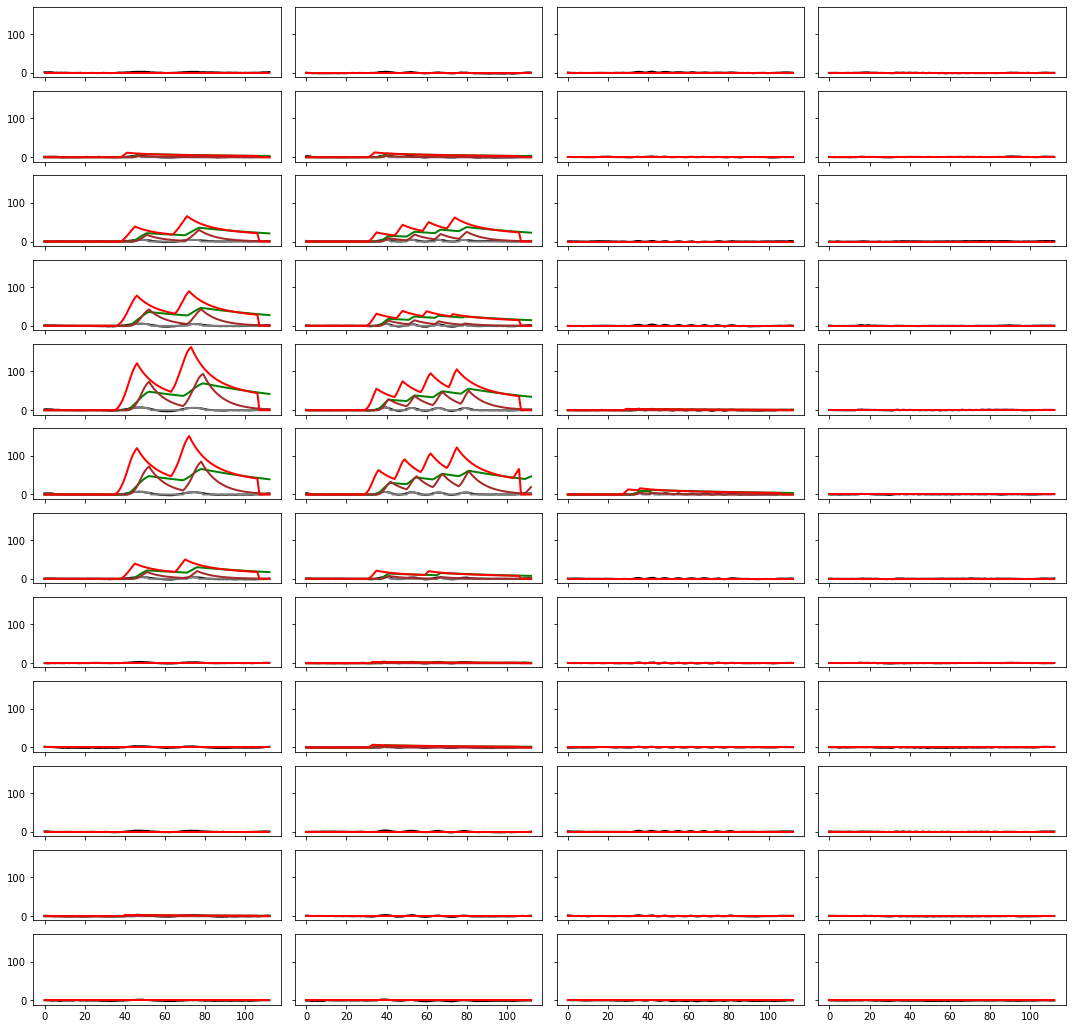

In [22]:
#model_p = fit_params()
T4Ca_model = Ca_model(T4_arclight, model_para, fig_size=(15,15),plot=True)
#plot_data([T4_Gcamp, T4Ca_model])

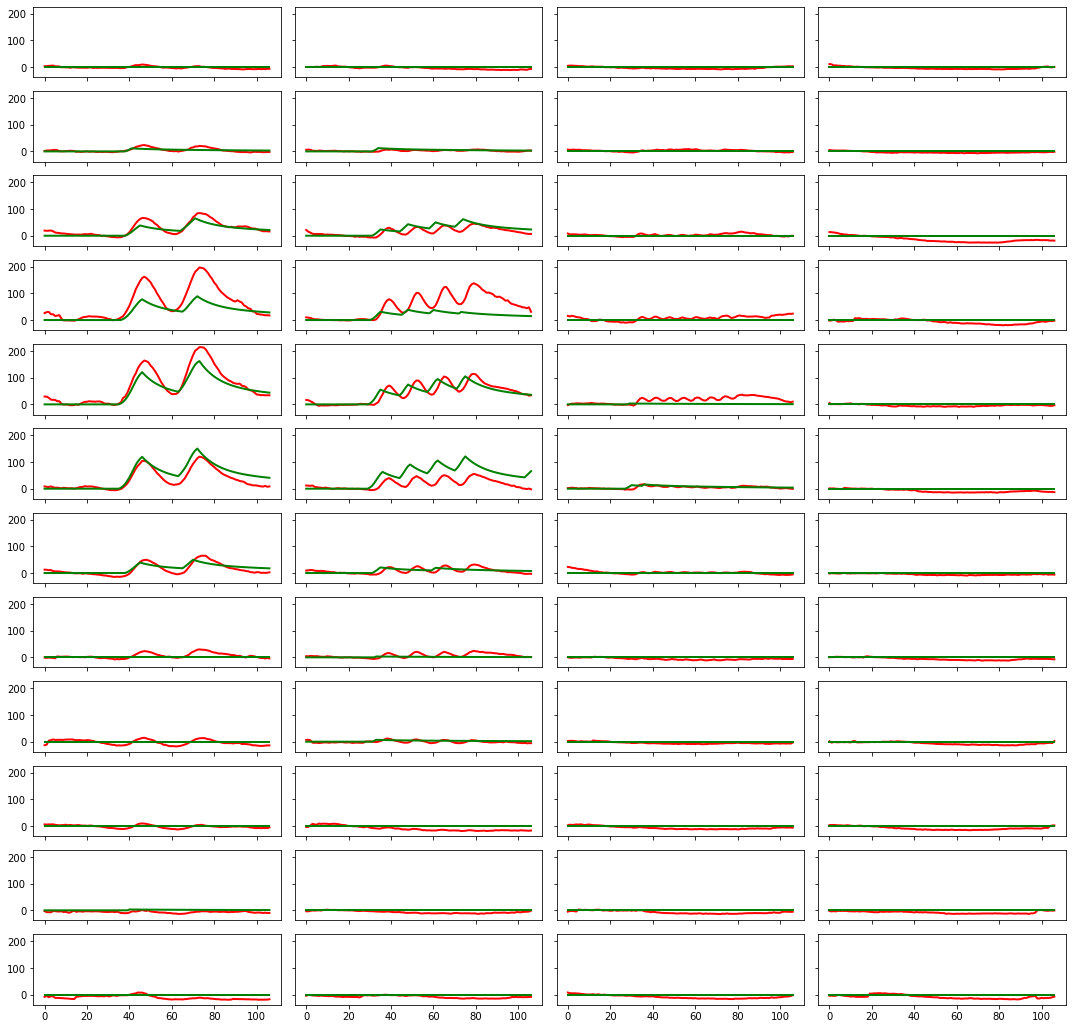

In [23]:
velocity = [15, 30, 60, 120]
utils.plot_data([T4_gcamp[0:107,:], T4Ca_model[0:107,:]],fig_size=(15,15),speed=velocity,c=['r','g'])
#plt.savefig('figures/scipyminimize/NewModel/CombinedGratingEdge_Gratings_Arclight_Gcamp_scipy_NewModel.pdf',dpi=1000)

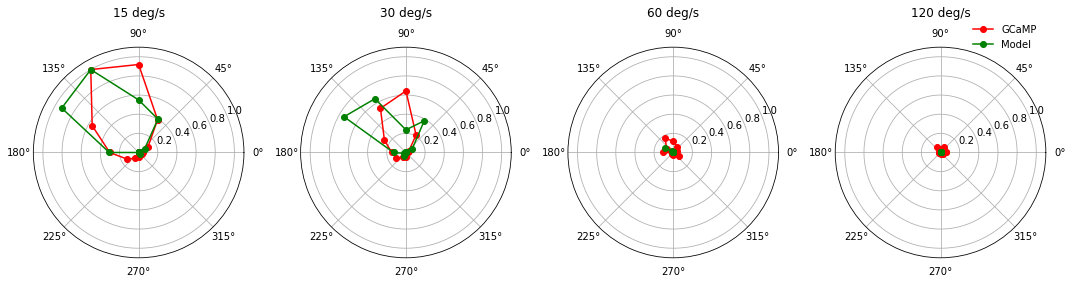

In [28]:
data_list = [T4_gcamp, T4Ca_model]
velocity = [15, 30, 60, 120]
peak_tuning = utils.calc_peaktuning(data_list, speed=velocity)
utils.plot_oripeaktuning(data_list,speed=velocity, label=['GCaMP','Model'],fig_size=(15,4), ylim1=(0.0,1.1),ylim2=(0.0,1.1),color=['r','g'],title='Speed_Ori_Tuning');